# Export YoloNAS to ONNX

In [1]:
# Load libraries
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime
from super_gradients.training.utils.media.image import load_image
from super_gradients.training import models
from super_gradients.conversion import DetectionOutputFormatMode
from super_gradients.training.utils.detection_utils import DetectionVisualization


The console stream is logged into /home/martin/sg_logs/console.log


[2024-03-28 11:07:35] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


[WARNING]No module named 'pycocotools'


I0328 11:07:41.226702 126928639508928 env_sanity_check.py:112] numpy==1.26.4 does not satisfy requirement numpy<=1.23


In [3]:
# Load trained model

model = models.get(
    'yolo_nas_s',
    num_classes=1,
    checkpoint_path="/home/martin/Projects/ukw/ukw/model/yolo_nas/weights/yolo_nas_2_best.pth"
)


export_result = model.export(
    "/home/martin/Projects/ukw/ukw/model/yolo_nas/weights/yolo_nas_2_best.onnx",
    confidence_threshold = 0.45,
    nms_threshold = 0.5,
    num_pre_nms_predictions = 100,
    max_predictions_per_image = 50,
    output_predictions_format = DetectionOutputFormatMode.FLAT_FORMAT,
    #engine=ExportTargetBackend.TENSORRT
)
export_result

Successfully loaded model weights from /home/martin/Projects/ukw/ukw/model/yolo_nas/weights/yolo_nas_2_best.pth EMA checkpoint.

/home/martin/Projects/ukw/ukw/model/.venv/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:5859: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


Model exported successfully to /home/martin/Projects/ukw/ukw/model/yolo_nas/weights/yolo_nas_2_best.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=100
    max_predictions_per_image=50
    nms_threshold=0.5
    confidence_threshold=0.45
    output_predictions_format=flat

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("/home/martin/Projects/ukw/ukw/model/yolo_nas/weights/yolo_nas_2_best.onnx

In [3]:
# Load and preprocess image for testing

image = load_image("/home/martin/Desktop/ukw/test_def.jpeg")
image = cv2.resize(image, (640, 640))
image_bchw = np.transpose(np.expand_dims(image, 0), (0, 3, 1, 2))

In [4]:
session = onnxruntime.InferenceSession("/home/martin/Projects/ukw/ukw/model/yolo_nas/weights/ckpt_best.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

start = time.perf_counter()
result = session.run(outputs, {inputs[0]: image_bchw})
end = time.perf_counter()

print(f"Time: {end-start} s")
print(result)

/home/martin/Projects/ukw/ukw/model/.venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Time: 0.3964638939942233 s
[array([], shape=(0, 7), dtype=float32)]


In [5]:
flat_predictions = result
for (_, x_min, y_min, x_max, y_max, confidence, class_id) in flat_predictions[0]:
    class_id = int(class_id)
    print(f"Detected object with class_id={class_id}, confidence={confidence}, x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

In [6]:

def show_predictions_from_flat_format(image, predictions):
    [flat_predictions] = predictions

    image = image.copy()
    class_names = ['smoke'] #COCO_DETECTION_CLASSES_LIST
    color_mapping = DetectionVisualization._generate_color_mapping(len(class_names))

    for (sample_index, x1, y1, x2, y2, class_score, class_index) in flat_predictions[flat_predictions[:, 0] == 0]:
        class_index = int(class_index)
        image = DetectionVisualization.draw_box_title(
                    image_np=image,
                    x1=int(x1),
                    y1=int(y1),
                    x2=int(x2),
                    y2=int(y2),
                    class_id=class_index,
                    class_names=class_names,
                    color_mapping=color_mapping,
                    box_thickness=2,
                    pred_conf=class_score,
                )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

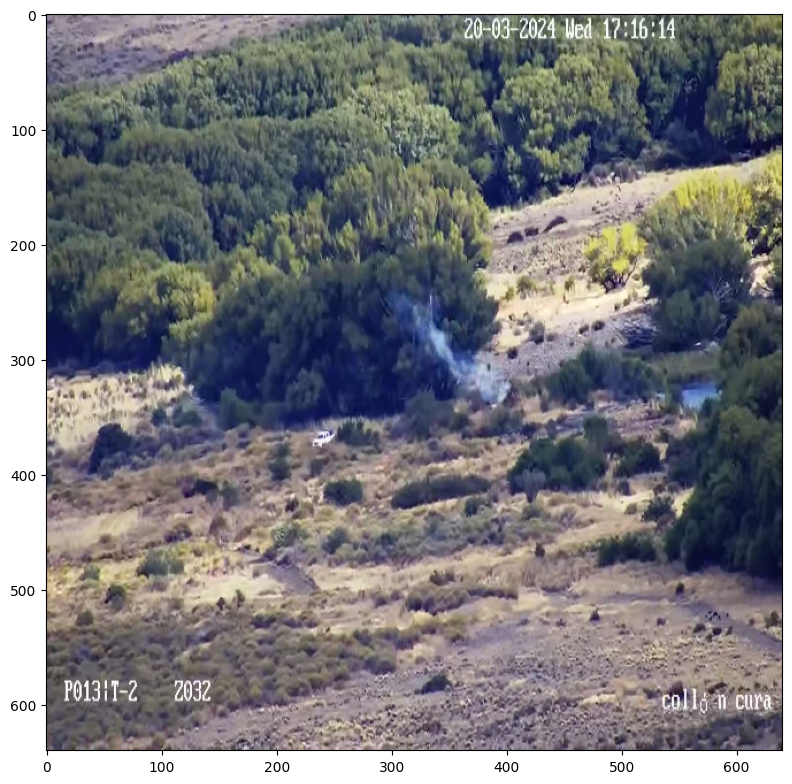

In [7]:
show_predictions_from_flat_format(image, result)